In [1]:
!pip install gdown
!gdown 1oBxHC16Vpm-_9xWkuM43MHGQMMVijyJA
!gdown 1ZOqLUa0aVHzsb3iBBRJAU2zAohq7Jzzo

Downloading...
From (uriginal): https://drive.google.com/uc?id=1oBxHC16Vpm-_9xWkuM43MHGQMMVijyJA
From (redirected): https://drive.google.com/uc?id=1oBxHC16Vpm-_9xWkuM43MHGQMMVijyJA&confirm=t&uuid=ceeba433-7444-4e4e-a1a3-5cbcb4671ed1
To: /kaggle/working/good_ffhq_full_512.zip
100%|█████████████████████████████████████████| 827M/827M [00:07<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZOqLUa0aVHzsb3iBBRJAU2zAohq7Jzzo
To: /kaggle/working/ganspace_fastgan_components.csv
100%|██████████████████████████████████████| 1.31M/1.31M [00:00<00:00, 86.7MB/s]


In [2]:
!unzip /kaggle/working/good_ffhq_full_512.zip

Archive:  /kaggle/working/good_ffhq_full_512.zip
   creating: good_ffhq_full_512/
  inflating: good_ffhq_full_512/diffaug.py  
  inflating: good_ffhq_full_512/eval.py  
  inflating: good_ffhq_full_512/generate_video.py  
  inflating: good_ffhq_full_512/model_s.py  
  inflating: good_ffhq_full_512/models.py  
  inflating: good_ffhq_full_512/new_modules.py  
  inflating: good_ffhq_full_512/operation.py  
  inflating: good_ffhq_full_512/style_mix.py  
  inflating: good_ffhq_full_512/train.py  
  inflating: good_ffhq_full_512/train_backtracking_all.py  
  inflating: good_ffhq_full_512/train_backtracking_one.py  
  inflating: good_ffhq_full_512/train_d_as_ae.py  
  inflating: good_ffhq_full_512/args.txt  
   creating: good_ffhq_full_512/models/
  inflating: good_ffhq_full_512/models/all_100000.pth  
   creating: good_ffhq_full_512/images/
  inflating: good_ffhq_full_512/images/73000.jpg  
  inflating: good_ffhq_full_512/images/18000.jpg  
  inflating: good_ffhq_full_512/images/59000.jpg  
 

In [3]:
%cd /kaggle/working/good_ffhq_full_512

/kaggle/working/good_ffhq_full_512


In [4]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from models import Generator

In [7]:
G = Generator(nz=256, im_size=512).to(device)
checkpoint = torch.load("models/all_100000.pth", map_location=lambda a,b: a)
checkpoint['g_ema'] = {k.replace('module.', ''): v for k, v in checkpoint['g'].items()}
G.load_state_dict(checkpoint['g_ema'])

<All keys matched successfully>

In [8]:
def gen_samples(path, G, n_samples, batch_size, device):
    n_iter = n_samples // batch_size
    for i in range(n_iter):
        with torch.no_grad():
            z = G.init(torch.randn([batch_size, 256]).to(device)).view(batch_size, -1)

        if os.path.exists(path):
            with open(path, "ab") as f:
                np.savetxt(f, z.cpu().numpy(), delimiter=",")
        else:
            np.savetxt(path, z.cpu().numpy(), delimiter=",")
    return np.loadtxt(os.path.join(path), delimiter=",")

In [9]:
from sklearn.decomposition import PCA

In [10]:
path = "/kaggle/working/ganspace_fastgan_components.csv"
if os.path.exists(path):
    pc = np.loadtxt(path, delimiter=",")
else:
    n_samples = 10000
    batch_size = 50
    vectors = gen_samples(path, G, n_samples, batch_size, device)
    pca = PCA(n_components=200)
    pca.fit(vectors)
    pc = pca.components_
    x = pca.transform(vectors)
    z_list = []
    for i in  range(10000//50):
        z = torch.randn([batch_size, 256]).numpy()
        z_list.append(z)
    z = np.concatenate(z_list)
    pc = np.linalg.lstsq(x, z)[0]

In [11]:
pc.shape

(200, 256)

In [12]:
z = torch.randn([5, 256]).to(device) 

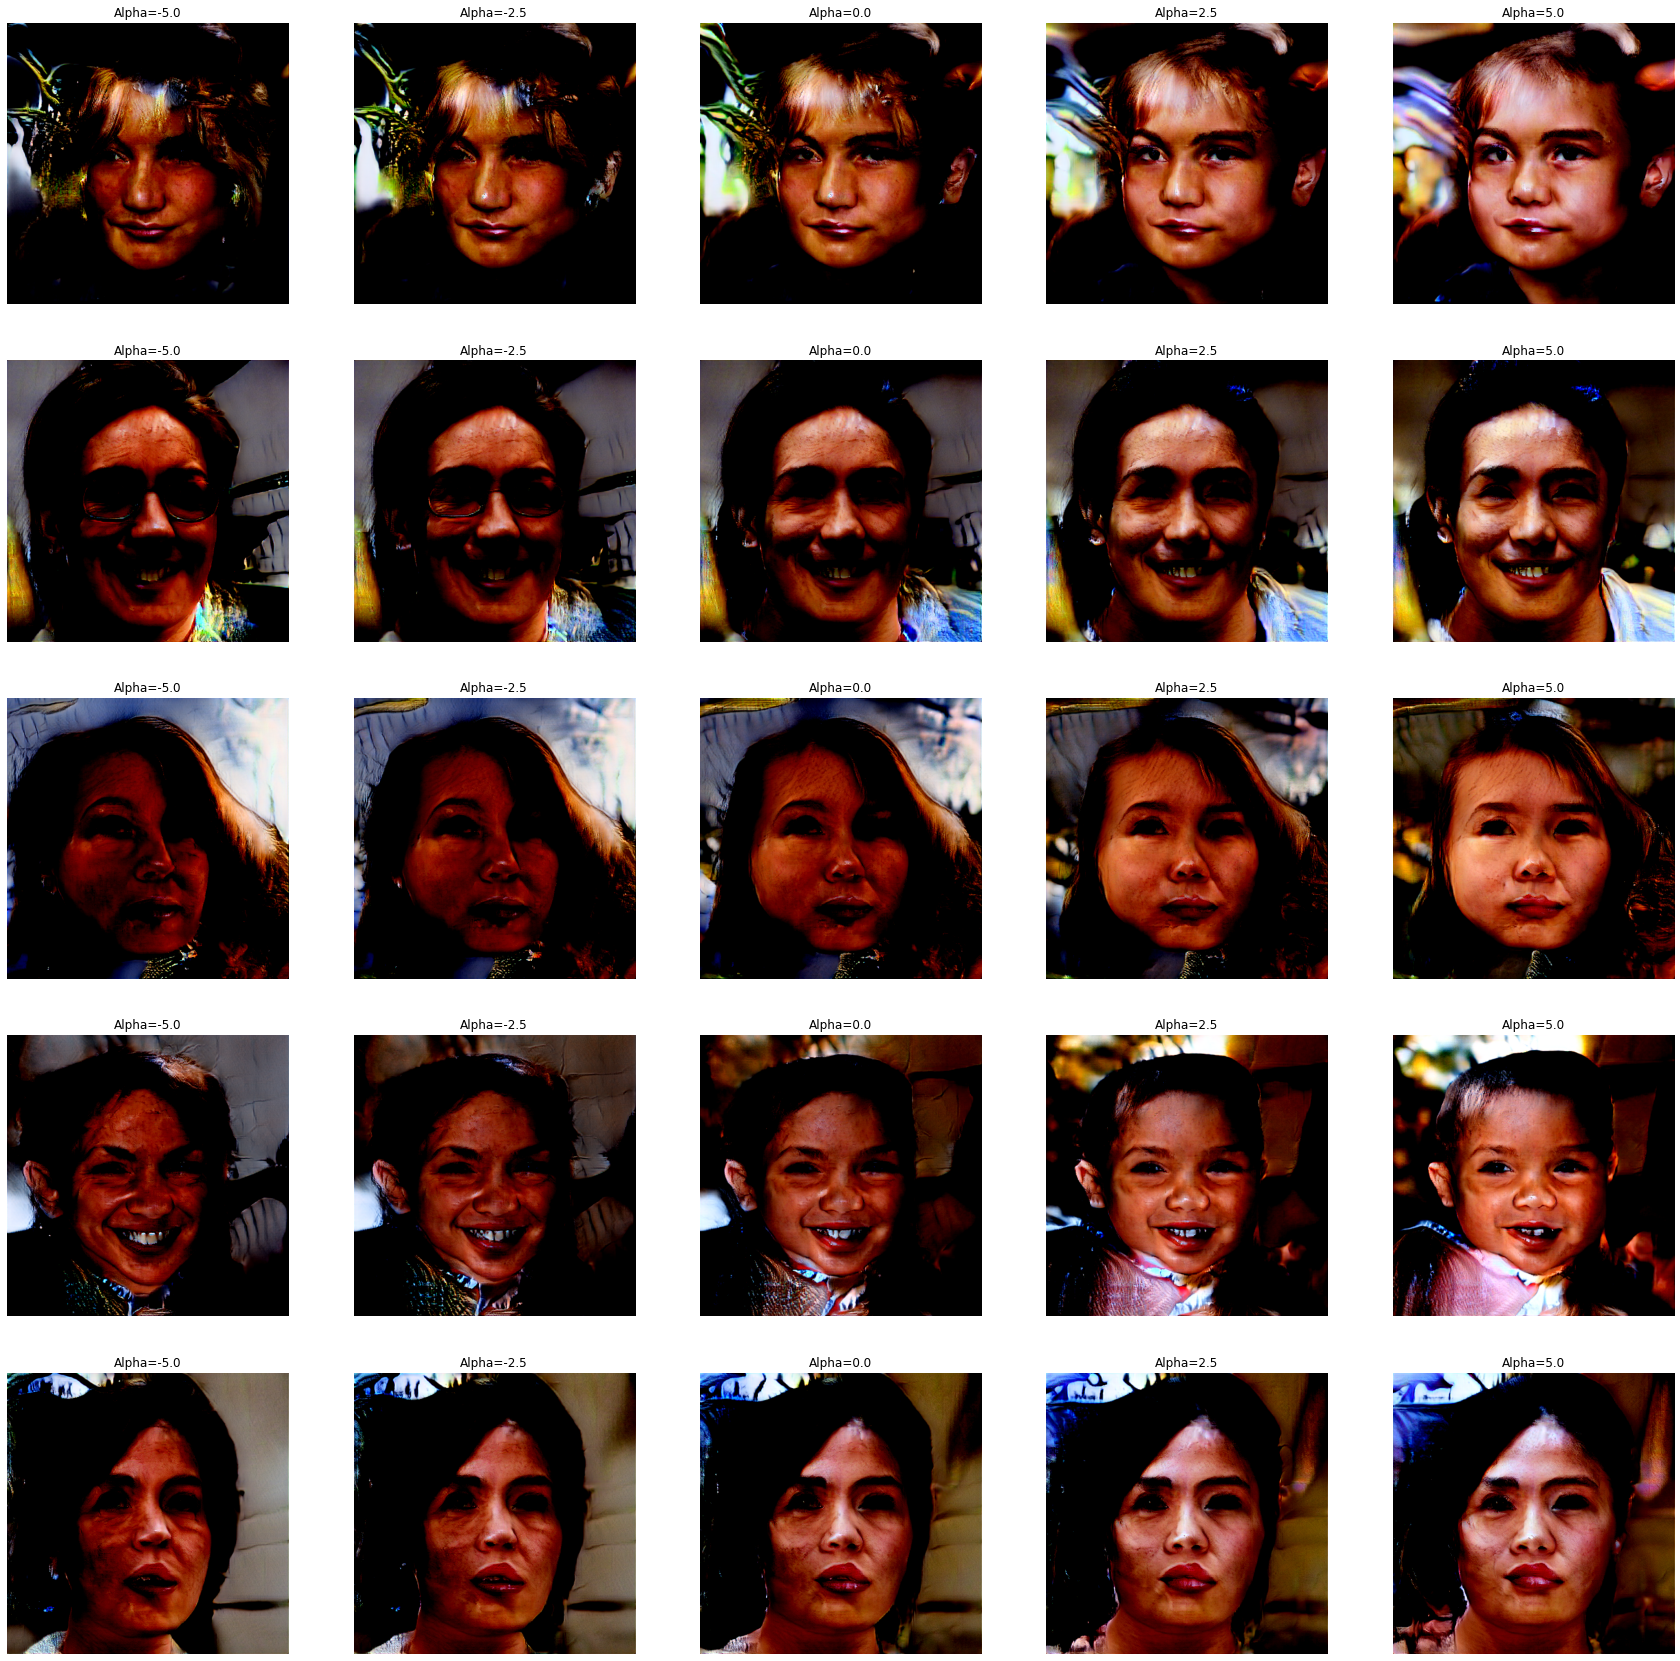

In [13]:
alphas = np.linspace(-5, 5, 5)
edits = torch.tensor(alphas.reshape(-1,1)*pc[15]/np.linalg.norm(pc[15]), dtype=torch.float).to(device)
fig, axs = plt.subplots(5,5, figsize=(30,30))

for idx in range(5):
    imgs = G(z[idx]+edits)[0]
    for i, img in enumerate(imgs):
        out = img.permute([1,2,0]).detach().cpu().numpy()
        axs[idx, i].axis('off')
        axs[idx, i].imshow(out)
        axs[idx, i].set_title(f"Alpha={alphas[i]}")

In [14]:
%cd /kaggle/working

/kaggle/working


In [15]:
import os
from tqdm import tqdm
from torchvision.utils import save_image

In [16]:
z_list = []
batch_size=10
for i in range(100):
    z_list.append(torch.randn([batch_size, 256]))

In [17]:
os.makedirs("original", exist_ok=True)
for i in tqdm(range(100)):
    z = z_list[i].to(device)
    with torch.no_grad():
        imgs = G(z)[0]
    for idx, img in enumerate(imgs):
        save_image(img, f'original/img{i*batch_size+idx}.png')

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [18]:
batch_size=10
os.makedirs("ganspace_fastgan", exist_ok=True)
for i in tqdm(range(100)):
    z = z_list[i].to(device)
    c = torch.randint(0, 20, [batch_size], device='cuda')
    shifts = torch.randn(c.shape, device='cuda')
    shifts = 6.0 * shifts

    shifts[(shifts < 0.5) & (shifts > 0)] = 0.5
    shifts[(shifts > -0.5) & (shifts < 0)] = -0.5
    edits = torch.zeros([batch_size, 256], device='cuda')
    for idx in range(batch_size):
        edits[idx] = shifts[idx] * torch.tensor(pc[c[idx]]/np.linalg.norm(pc[c[idx]]), device="cuda")
    with torch.no_grad():
        imgs = G(z)
        imgs_shifted = G(z+edits)[0]
    for idx, img_shifted in enumerate(imgs_shifted):
        save_image(img_shifted, f'ganspace_fastgan/img{i*batch_size+idx}.png')

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


In [19]:
!pip install pytorch-fid

In [20]:
!python -m pytorch_fid /kaggle/working/ganspace_fastgan /kaggle/working/original

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|███████████████████████████████████████| 91.2M/91.2M [00:00<00:00, 165MB/s]
100%|███████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]
FID:  24.220139687434653
